In [1]:
import yaml
from pathlib import Path

with open("../config.yaml", "r") as f:
    config = yaml.safe_load(f)

config['databricks']['catalog'], config['databricks']['schema'], config["databricks"]["volume"]

('portfolio_catalog', 'databricks_pipeline', 'data')

In [3]:
def running_on_databricks():
    """Detect if running in Databricks environment"""
    try:
        import pyspark.dbutils  # only available in Databricks
        return True
    except ImportError:
        return False

IS_DATABRICKS = running_on_databricks()
print(IS_DATABRICKS)

False


In [4]:
from pyspark.sql import functions as F
# from helper import run_forecast, aggregate_to_granularity, build_features, train_test_split

from helper import (
    aggregate_to_granularity, assert_unique_series_rows, build_features,
    train_test_split, model_factory, assemble_global_pipeline, fit_global_model, predict_global,
    compute_metrics, fit_predict_local, rolling_backtest, run_forecast, plot_forecast, plot_train_test_forecast)

from pyspark.sql import SparkSession

# Give Spark way more memory since you have 32GB RAM available
spark = SparkSession.builder \
    .appName("TimeSeriesForecast") \
    .config("spark.driver.memory", "12g") \
    .config("spark.executor.memory", "12g") \
    .config("spark.driver.maxResultSize", "4g") \
    .config("spark.sql.shuffle.partitions", "16") \
    .config("spark.default.parallelism", "8") \
    .config("spark.sql.adaptive.enabled", "true") \
    .config("spark.sql.adaptive.coalescePartitions.enabled", "true") \
    .getOrCreate()


In [8]:
# Load data (must include columns: date, sales, family, store_nbr)
if IS_DATABRICKS:
    df_raw = spark.read.format("delta").table('portfolio_catalog.databricks_pipeline.silver_training')

else:
    df_raw = (   
        spark.read.parquet('../notebooks/data/train.parquet')

        .withColumn("date", F.to_date(F.col("date"))))


In [9]:

cfg = {
    "data": {"date_col": "date", "target_col": "sales", "group_cols": ["family", "store_nbr"],
             "freq": "D", "min_train_periods": 56},
    "aggregation": {"target_agg": "sum", "extra_numeric_aggs": {"dcoilwtico": "mean", "onpromotion": "sum"}},
    "features": {"lags": [1,7,14,28], "mas": [7,28], "add_time_signals": True},
    "split": {"mode": "horizon", "train_end_date": "", "test_horizon": 28},
    "model": {"type": "spark_gbt", "params": {"maxDepth": 7, "maxIter": 120}},
    # "model": {"type": "spark_lgbt", "params": {"maxDepth": 7, "maxIter": 120}},
    "evaluation": {"mase_seasonality": 7, "backtest": {"enabled": True, "folds": 4, "fold_horizon": 14, "step": 14}}
}

# --- Step 1: Features ---
df_feat = build_features(df_raw, cfg["data"]["date_col"], cfg["data"]["target_col"],
                         cfg["data"]["group_cols"], cfg["features"]["lags"], cfg["features"]["mas"],
                         cfg["features"]["add_time_signals"], pre_aggregate=True,
                         target_agg=cfg["aggregation"]["target_agg"],
                         extra_numeric_aggs=cfg["aggregation"].get("extra_numeric_aggs"))
display(df_feat.limit(5))

# --- Step 2: Split ---
train, test = train_test_split(df_feat, cfg["data"]["date_col"], cfg["data"]["group_cols"],
                               cfg["split"]["mode"], cfg["split"]["train_end_date"], cfg["split"]["test_horizon"],
                               cfg["data"]["min_train_periods"])

# --- Step 3: Train (global model) ---
est = model_factory(cfg["model"]["type"], cfg["model"]["params"])
feature_cols = [c for c in train.columns if c not in cfg["data"]["group_cols"] + [cfg["data"]["date_col"], cfg["data"]["target_col"], "label"]]
model = fit_global_model(train, cfg["data"]["target_col"], cfg["data"]["group_cols"], feature_cols, est)

# --- Step 4: Predict ---
pred = predict_global(model, test, cfg["data"]["group_cols"], cfg["data"]["date_col"], cfg["data"]["target_col"])
display(pred.limit(10))

# --- Step 5: Metrics ---
by_series, portfolio = compute_metrics(pred, cfg["data"]["date_col"], "y", "prediction",
                                       cfg["data"]["group_cols"], cfg["evaluation"]["mase_seasonality"])
display(by_series.orderBy("wMAPE")); display(portfolio)

# # --- Optional: Backtest ---
# from smartforecast.forecasting import aggregate_to_granularity, rolling_backtest
# df_agg = aggregate_to_granularity(df_raw, cfg["data"]["date_col"], cfg["data"]["target_col"],
#                                   cfg["data"]["group_cols"], cfg["aggregation"]["target_agg"],
#                                   cfg["aggregation"].get("extra_numeric_aggs"))
# bt = rolling_backtest(df_agg, cfg["data"]["date_col"], cfg["data"]["target_col"], cfg["data"]["group_cols"],
#                       feature_params={"lags": cfg["features"]["lags"], "mas": cfg["features"]["mas"], "add_time_signals": cfg["features"]["add_time_signals"], "freq": cfg["data"]["freq"]},
#                       model_type=cfg["model"]["type"], model_params=cfg["model"]["params"],
#                       folds=cfg["evaluation"]["backtest"]["folds"], fold_horizon=cfg["evaluation"]["backtest"]["fold_horizon"],
#                       step=cfg["evaluation"]["backtest"]["step"], mase_seasonality=cfg["evaluation"]["mase_seasonality"])
# display(bt)


DataFrame[family: string, store_nbr: int, date: date, sales: double, dcoilwtico: double, onpromotion: bigint, lag_1: double, lag_7: double, lag_14: double, lag_28: double, ma_7: double, ma_28: double, dow: int, dom: int, weekofyear: int, month: int, year: int]

25/12/26 18:26:04 WARN SparkStringUtils: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.
25/12/26 18:27:24 WARN DAGScheduler: Broadcasting large task binary with size 1002.9 KiB
25/12/26 18:27:24 WARN DAGScheduler: Broadcasting large task binary with size 1012.5 KiB
25/12/26 18:27:24 WARN DAGScheduler: Broadcasting large task binary with size 1016.8 KiB
25/12/26 18:27:25 WARN DAGScheduler: Broadcasting large task binary with size 1017.3 KiB
25/12/26 18:27:25 WARN DAGScheduler: Broadcasting large task binary with size 1018.3 KiB
25/12/26 18:27:25 WARN DAGScheduler: Broadcasting large task binary with size 1019.1 KiB
25/12/26 18:27:25 WARN DAGScheduler: Broadcasting large task binary with size 1021.5 KiB
25/12/26 18:27:26 WARN DAGScheduler: Broadcasting large task binary with size 1026.2 KiB
25/12/26 18:27:26 WARN DAGScheduler: Broadcasting large task binary with size 1035.6 KiB
25/12/26 1

DataFrame[family: string, store_nbr: int, date: date, y: double, prediction: double]

DataFrame[family: string, store_nbr: int, sMAPE: double, wMAPE: double, MASE: double]

DataFrame[sMAPE: double, wMAPE: double, MASE: double, level: string]

In [10]:
by_series.sort("wMAPE").show(35)

25/12/26 18:30:28 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


+-------------+---------+--------------------+--------------------+-------------------+
|       family|store_nbr|               sMAPE|               wMAPE|               MASE|
+-------------+---------+--------------------+--------------------+-------------------+
|    GROCERY I|        8| 0.04963604759406781| 0.04976866794455462| 0.4097185328301861|
|      POULTRY|        6| 0.05536483840939756| 0.05526010209904835| 0.5135793104467085|
|      PRODUCE|        4|0.054418265171925696|0.055940612503547926| 0.5609260483183071|
|      PRODUCE|        7|0.055698931279115835| 0.05643051586532866| 0.6938567900189423|
|        DAIRY|        3| 0.05656453427997042| 0.05975904864736496| 0.7136373582414492|
|         EGGS|        3|0.061045740378303306| 0.06376246385218413| 0.7936135882632175|
|        DAIRY|       45| 0.06582680209896039| 0.06535000318216687| 0.6129658635154249|
|        DAIRY|       31| 0.07173342610887955| 0.06546883297094377|0.44335746184799596|
| BREAD/BAKERY|        3| 0.0679

In [11]:
portfolio.show()

+------------------+-------------------+-----------------+---------+
|             sMAPE|              wMAPE|             MASE|    level|
+------------------+-------------------+-----------------+---------+
|0.6497717400629907|0.14157574361832428|0.698233046838809|portfolio|
+------------------+-------------------+-----------------+---------+



In [12]:
pred.toPandas()

,family,store_nbr,date,y,prediction
0,AUTOMOTIVE,10,2017-07-19,0.000000,-1.043582
1,AUTOMOTIVE,10,2017-07-20,1.000000,-0.763207
2,AUTOMOTIVE,10,2017-07-21,0.000000,-1.244965
3,AUTOMOTIVE,10,2017-07-22,1.000000,1.134701
4,AUTOMOTIVE,10,2017-07-23,3.000000,2.287604
...,...,...,...,...,...
49891,SEAFOOD,50,2017-08-11,22.524000,8.696334
49892,SEAFOOD,50,2017-08-12,15.801001,14.202467
49893,SEAFOOD,50,2017-08-13,41.527000,21.210594
49894,SEAFOOD,50,2017-08-14,12.242000,16.979239


In [13]:
family_list = list(pred.toPandas()['family'].unique())
i = 0
family_list[i]

'AUTOMOTIVE'

In [14]:
from pyspark.sql import DataFrame, Window
import matplotlib.pyplot as plt
from typing import Any, Dict, List, Tuple


def plot_forecast(
    pred_df: DataFrame,
    date_col: str,
    actual_col: str,
    pred_col: str,
    group_cols: List[str],
    series_id: Dict[str, str] = None,
    title: str = "Forecast vs Actual",
    figsize: Tuple[int, int] = (10, 5),
):
    """
    Plot actual vs predicted for a single series.
    Parameters
    ----------
    pred_df : DataFrame
        Must include date_col, actual_col, pred_col, and group_cols.
    series_id : dict
        Filter for one series, e.g., {"family": "BEVERAGES"} or {"family": "BEVERAGES", "store_nbr": "1"}.
    """
    # Filter for one series
    # After filtering and sorting
    
    pdf = pred_df.sort_values(date_col)
    print(pdf.head(5))

    # Aggregate only if needed
    if pdf.duplicated(subset=[date_col]).any():
        pdf = (
            pdf.groupby([date_col] + group_cols, as_index=False)
            .agg({actual_col: "sum", pred_col: "sum"})
            .sort_values(date_col)
        )

    if series_id:
        for k, v in series_id.items():
            pdf = pdf[pdf[k] == v]

    pdf = pdf.sort_values(date_col)

    plt.figure(figsize=figsize)
    plt.plot(pdf[date_col], pdf[actual_col], label="Actual", color="blue")
    plt.plot(
        pdf[date_col], pdf[pred_col], label="Prediction", color="orange", linestyle="--"
    )
    plt.title(title)
    plt.xlabel("Date")
    plt.ylabel(actual_col)
    plt.legend()
    plt.grid(True)
    plt.show()

In [15]:
pred_df = pred.toPandas()

In [49]:
# Example: plot for one family
selected_family = family_list[i]
plot_forecast(
    pred_df=pred_df,
    date_col=cfg["data"]["date_col"],
    actual_col="y",
    pred_col="prediction",
    group_cols=['family'], #cfg["data"]["group_cols"],
    series_id={"family": selected_family},
    title=f"Family {selected_family} Forecast"
)
i +=1


IndexError: list index out of range

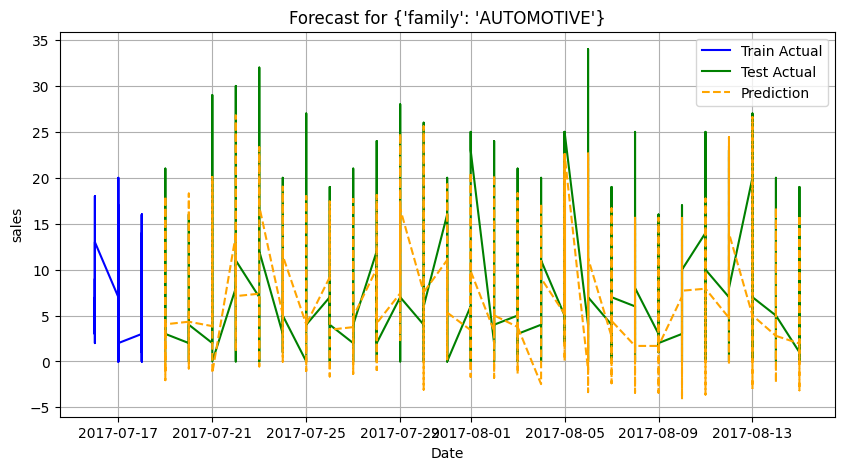

In [17]:
plot_train_test_forecast(train, test, pred,
                         date_col=cfg["data"]["date_col"],
                         target_col="sales",
                         pred_col="prediction",
                         group_cols=cfg["data"]["group_cols"],
                         series_id={"family": selected_family}, last_n_train=120)

i += 1

In [0]:
run_forecast(df, cfg=cfg)

In [0]:
agg_cols = ['family', 'store_nbr', 'state', 'city', 'type', 'cluster'] # there is one store per city and type and cluster so adding those feature is redundant
agg_cols = ['family', 'store_nbr'] # there is one store per city and type and cluster so adding those feature is redundant

# agg_cols = ['family']

df_agg = aggregate_to_granularity(
    df=df,
    date_col='date',
    target_col='sales',
    group_cols=agg_cols,
    agg="sum",  # sales are additive
    # extra_numeric_aggs={"dcoilwtico": "mean"}  # optional
)
print(df_agg.count())
df_agg.show(2)

df_feat = build_features(
    df=df_agg,
    date_col='date',
    target_col='sales',
    group_cols=agg_cols,
    lags=[1, 7, 14, 28],
    mas=[7, 28],
    # add_time_signals=cfg["features"]["add_time_signals"]
)
df_feat.show(10)
print(df_feat.count())
# df_feat.sort(agg_cols + ["date"]).select(agg_cols + ['date', 'sales', 'dcoilwtico', 'lag_1', 'lag_2']).show(10)

In [0]:
from icecream import ic

d, a, f, s, m, e = (
    cfg["data"],
    cfg.get("aggregation", {}),
    cfg["features"],
    cfg["split"],
    cfg["model"],
    cfg["evaluation"],
)

df_agg = aggregate_to_granularity(
    df_raw,
    d["date_col"],
    d["target_col"],
    d["group_cols"],
    agg=a.get("target_agg", "sum"),
    extra_numeric_aggs=a.get("extra_numeric_aggs"),
)
ic()

bt = rolling_backtest(
    df_agg,
    d["date_col"],
    d["target_col"],
    d["group_cols"],
    feature_params={
        "lags": f["lags"],
        "mas": f["mas"],
        "add_time_signals": f["add_time_signals"],
        "freq": d.get("freq", "D"),
    },
    model_type=m["type"],
    model_params=m["params"],
    folds=e["backtest"]["folds"],
    fold_horizon=e["backtest"]["fold_horizon"],
    step=e["backtest"]["step"],
    mase_seasonality=e["mase_seasonality"],
)


In [0]:
bt.show()

In [0]:
# agg_cols = ['family', 'store_nbr']
agg_cols = ['family']

df_agg = aggregate_to_granularity(
    df=df,
    date_col='date',
    target_col='sales',
    group_cols=agg_cols,
    agg="sum",  # sales are additive
    # extra_numeric_aggs={"price": "mean", "promo_spend": "sum"}  # optional
)

df_feat = build_features(
    df=df_agg,
    date_col='date',
    target_col='sales',
    group_cols=agg_cols,
    lags=[1,2],
    mas=[1,2],
    # add_time_signals=cfg["features"]["add_time_signals"]
)
print(df_feat.count())
df_feat.sort(agg_cols + ["date"]).select(agg_cols + ['date', 'sales', 'lag_1', 'lag_2']).show(10)
df_feat.show(10)

In [0]:
train, test = train_test_split(df=df_feat, date_col='date', group_cols=agg_cols, mode='horizon', test_horizon=28)
train.show(2)
test.show(2)

In [0]:
agg_cols = ['family', 'family']
# agg_cols = ['family']

df_agg = aggregate_to_granularity(
    df=df,
    date_col='date',
    target_col='sales',
    group_cols=agg_cols,
    agg="sum",  # sales are additive
    # extra_numeric_aggs={"price": "mean", "promo_spend": "sum"}  # optional
)

df_feat = build_features(
    df=df_agg,
    date_col='date',
    target_col='sales',
    group_cols=agg_cols,
    lags=[1,2],
    mas=[1,2],
    # add_time_signals=cfg["features"]["add_time_signals"]
)
print(df_feat.count())
df_feat.sort(agg_cols + ["date"]).select(agg_cols + ['date', 'sales', 'lag_1', 'lag_2']).show(10)

In [0]:
dfx = build_features(df, "date", "sales", ["family", "store_nbr"], lags=[1, 2], mas=[1])
print(dfx.count())
dfx.sort(["family", "store_nbr", "date"]).select(['family', 'store_nbr', 'date', 'sales', 'lag_1', 'lag_2']).show(10)

In [0]:
dfx = build_features(df, "date", "sales", ["family"], lags=[1, 2], mas=[1])
print(dfx.count())
dfx.sort(["family", "store_nbr", "date"]).select(['family', 'store_nbr', 'date', 'sales', 'lag_1', 'lag_2']).show(10)

In [0]:
# Load config from YAML or dict
import yaml, json
cfg = yaml.safe_load(open("forecast_config.yaml"))

out = run_forecast(df_feat, cfg)

display(out["predictions"])         # per-group predictions on test window
# display(out["metrics_portfolio"])   # wMAPE, sMAPE, MASE overall
# display(out["metrics_by_series"])   # same metrics by series
# display(out["backtest"])            # rolling-origin backtest summary (if enabled)
